# Predictive Maintenance Models - Experiments EDA's

## Impor Required Libraries

In [1]:
import os
import sys
import json
import textwrap
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import gaussian_kde
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle

from imblearn.over_sampling import SMOTENC

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, LabelEncoder

## Dataset Loading

Dataset Sources:
- https://www.kaggle.com/datasets/shivamb/machine-predictive-maintenance-classification
- https://www.kaggle.com/datasets/dnkumars/industrial-equipment-monitoring-dataset
- https://www.kaggle.com/datasets/jeleeladekunlefijabi/preventive-maintenance-for-marine-engines

### Load the Datasets

In [2]:
df_predictive_maintenance = pd.read_csv('data/predictive_maintenance.csv')
df_equipment_anomaly = pd.read_csv('data/equipment_anomaly_data.csv')
df_marine_engine = pd.read_csv('data/marine_engine_data.csv')

### Predictive Maintenance Dataset

In [3]:
df_predictive_maintenance.head()

,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,No Failure
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,No Failure
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,No Failure
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,No Failure
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,No Failure


### Equipment Anomaly Dataset

In [4]:
df_equipment_anomaly.head()

,temperature,pressure,vibration,humidity,equipment,location,faulty
0,58.180180,25.029278,0.606516,45.694907,Turbine,Atlanta,0.0
1,75.740712,22.954018,2.338095,41.867407,Compressor,Chicago,0.0
2,71.358594,27.276830,1.389198,58.954409,Turbine,San Francisco,0.0
3,71.616985,32.242921,1.770690,40.565138,Pump,Atlanta,0.0
4,66.506832,45.197471,0.345398,43.253795,Pump,New York,0.0


### Marine Engine Dataset

In [5]:
df_marine_engine.head()

,timestamp,engine_id,engine_temp,oil_pressure,fuel_consumption,vibration_level,rpm,engine_load,coolant_temp,exhaust_temp,running_period,fuel_consumption_per_hour,maintenance_status,failure_mode,engine_type,fuel_type,manufacturer
0,2023-01-01,ENG_001,79.816406,7.049409,1000.000000,4.366612,1770.214578,42.472407,78.323108,450.0,49.741791,100.0,Critical,Oil Leakage,4-stroke High-Speed,Diesel,MAN B&W
1,2023-01-08,ENG_001,98.982068,8.000000,6308.623817,3.732792,1677.238238,77.042858,100.000000,450.0,94.351515,100.0,Requires Maintenance,Oil Leakage,2-stroke Low-Speed,Diesel,Mitsubishi
2,2023-01-15,ENG_001,83.918153,8.000000,6444.402260,4.061372,1487.472085,63.919637,78.178337,450.0,120.095804,100.0,Normal,No Failure,2-stroke Medium-Speed,Diesel,Caterpillar
3,2023-01-22,ENG_001,81.887081,7.601603,4439.946613,3.999554,1548.624692,55.919509,82.896344,450.0,122.321555,100.0,Requires Maintenance,Mechanical Wear,2-stroke Medium-Speed,Diesel,MAN B&W
4,2023-01-29,ENG_001,78.550429,6.233033,3146.234038,4.520559,1441.151499,29.361118,80.791150,450.0,111.978460,100.0,Normal,No Failure,4-stroke High-Speed,Diesel,Wärtsilä


## Define the Category, Numeric and Target

In [6]:
# Predictive Maintenance Dataset
df_predictive_maintenance_id = ["UDI", "Product ID"]
df_predictive_maintenance_category = ["Type"]
df_predictive_maintenance_target = ["Target", "Failure Type"]
df_predictive_maintenance_numeric = ["Air temperature [K]", "Process temperature [K]", "Rotational speed [rpm]", "Torque [Nm]", "Tool wear [min]"]

# Equipment Anomaly Dataset
df_equipment_anomaly_category = ["equipment", "location"] 
df_equipment_anomaly_target = ["faulty"]
df_equipment_anomaly_numeric = ["temperature", "pressure", "vibration", "humidity"]

# Marine Engine Dataset
df_marine_engine_timestamp = ["timestamp"]
df_marine_engine_id = ["engine_id"]
df_marine_engine_category = ["fuel_type", "engine_type", "manufacturer"]
df_marine_engine_target = ["maintenance_status", "failure_mode"]
df_marine_engine_numeric = ["engine_temp", "oil_pressure", "fuel_consumption", "vibration_level", "rpm", "engine_load", "coolant_temp", "exhaust_temp", "running_period", "fuel_consumption_per_hour"]

## Auto Dataset Assessing

In [7]:
def assess_dataframe(df, target=None, high_card_threshold=0.5):
    print("Data Assessment Report")

    n_rows, n_cols = df.shape
    print(f"\nShape of Dataset: {n_rows} Rows x {n_cols} Columns")

    print("\nColumn Information:")
    info_table = pd.DataFrame({
        "DataType": df.dtypes,
        "Non-Null Count": df.notnull().sum(),
        "Null Count": df.isnull().sum(),
        "Null %": (df.isnull().sum() / n_rows * 100).round(2),
        "Unique Values": df.nunique(dropna=True),
        "Unique %": (df.nunique(dropna=True) / n_rows * 100).round(2),
    })
    print(info_table)

    dup_count = df.duplicated().sum()
    dup_percent = round((dup_count / n_rows) * 100, 2) if n_rows else 0.0
    print(f"\nDuplicate Rows: {dup_count} ({dup_percent}%)")

    const_cols = [c for c in df.columns if df[c].nunique(dropna=False) <= 1]
    print("\nConstant Columns:")
    print(const_cols if const_cols else "None")

    cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()
    high_card_cols = []
    for c in cat_cols:
        ratio = (df[c].nunique(dropna=True) / n_rows) if n_rows else 0.0
        if ratio >= high_card_threshold:
            high_card_cols.append((c, round(ratio*100, 2)))
    print("\nHigh Cardinality Categorical Columns (>= {:.0f}% Unique):".format(high_card_threshold*100))
    if high_card_cols:
        for c, pct in high_card_cols:
            print(f"- {c}: {pct}% Unique")
    else:
        print("None")

    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if num_cols:
        print("\nNumeric Columns Summary:")
        modes = {}
        if len(num_cols) > 0:
            mode_df = df[num_cols].mode(dropna=True)
            for c in num_cols:
                modes[c] = mode_df[c].iloc[0] if not mode_df.empty and c in mode_df else np.nan
        summary = pd.DataFrame({
            "Mean": df[num_cols].mean(numeric_only=True),
            "Median": df[num_cols].median(numeric_only=True),
            "Mode": pd.Series(modes),
            "Min": df[num_cols].min(numeric_only=True),
            "Q1": df[num_cols].quantile(0.25, numeric_only=True),
            "Q3": df[num_cols].quantile(0.75, numeric_only=True),
            "Max": df[num_cols].max(numeric_only=True),
            "Standard Deviation": df[num_cols].std(numeric_only=True),
            "Skewness": df[num_cols].skew(numeric_only=True),
            "Kurtosis": df[num_cols].kurt(numeric_only=True)
        }).round(4)
        print(summary)

        print("\nOutlier Counts (IQR method):")
        outlier_rows = []
        for c in num_cols:
            series = df[c].dropna()
            if series.empty:
                outlier_rows.append((c, 0, 0.0))
                continue
            q1 = series.quantile(0.25)
            q3 = series.quantile(0.75)
            iqr = q3 - q1
            if iqr == 0:
                outlier_rows.append((c, 0, 0.0))
                continue
            lower = q1 - 1.5 * iqr
            upper = q3 + 1.5 * iqr
            count = ((series < lower) | (series > upper)).sum()
            pct = round(count / len(series) * 100, 2)
            outlier_rows.append((c, int(count), pct))
        if outlier_rows:
            outlier_table = pd.DataFrame(outlier_rows, columns=["Column", "Outliers", "Outliers %"])
            print(outlier_table)

        print("\nPearson Correlation (Numeric):")
        pearson_corr = df[num_cols].corr(method="pearson")
        print(pearson_corr.round(3))

        print("\nSpearman Correlation (Numeric):")
        spearman_corr = df[num_cols].corr(method="spearman")
        print(spearman_corr.round(3))
    else:
        print("\nNo Numeric columns found.")

    print("\nColumns > 50% Missing Values:")
    high_missing = info_table[info_table["Null %"] > 50].sort_values("Null %", ascending=False)
    if not high_missing.empty:
        print(high_missing[["Null Count", "Null %"]])
    else:
        print("None")

    print("\nMemory Usage:")
    total_mem = df.memory_usage(deep=True).sum()
    print(f"Total: {total_mem} bytes ({round(total_mem/1024,2)} KB, {round(total_mem/(1024*1024),2)} MB)")
    memory_per_col = df.memory_usage(deep=True)
    memory_table = pd.DataFrame({"Bytes": memory_per_col}).sort_values("Bytes", ascending=False)
    print("\nPer Column Memory:")
    print(memory_table)

    if target is not None and target in df.columns:
        print(f"\nClass Balance for '{target}':")
        vc = df[target].value_counts(dropna=False)
        vp = df[target].value_counts(normalize=True, dropna=False).mul(100).round(2)
        bal = pd.DataFrame({"Count": vc, "Percent %": vp})
        print(bal)

    print("\nData Assessment Completed")

## Expl(ora/ana)tory Data Analysis - Predictive Maintenance Dataset

### Assessing Dataset with Different Target

In [8]:
assess_dataframe(df_predictive_maintenance, target=df_predictive_maintenance_target[0])


Data Assessment Report

Shape of Dataset: 10000 Rows x 10 Columns

Column Information:
                        DataType  Non-Null Count  Null Count  Null %  \
UDI                        int64           10000           0     0.0   
Product ID                object           10000           0     0.0   
Type                      object           10000           0     0.0   
Air temperature [K]      float64           10000           0     0.0   
Process temperature [K]  float64           10000           0     0.0   
Rotational speed [rpm]     int64           10000           0     0.0   
Torque [Nm]              float64           10000           0     0.0   
Tool wear [min]            int64           10000           0     0.0   
Target                     int64           10000           0     0.0   
Failure Type              object           10000           0     0.0   

                         Unique Values  Unique %  
UDI                              10000    100.00  
Product ID        

In [9]:
assess_dataframe(df_predictive_maintenance, target=df_predictive_maintenance_target[1])


Data Assessment Report

Shape of Dataset: 10000 Rows x 10 Columns

Column Information:
                        DataType  Non-Null Count  Null Count  Null %  \
UDI                        int64           10000           0     0.0   
Product ID                object           10000           0     0.0   
Type                      object           10000           0     0.0   
Air temperature [K]      float64           10000           0     0.0   
Process temperature [K]  float64           10000           0     0.0   
Rotational speed [rpm]     int64           10000           0     0.0   
Torque [Nm]              float64           10000           0     0.0   
Tool wear [min]            int64           10000           0     0.0   
Target                     int64           10000           0     0.0   
Failure Type              object           10000           0     0.0   

                         Unique Values  Unique %  
UDI                              10000    100.00  
Product ID        

### Histogram & KDE of Numeric Features

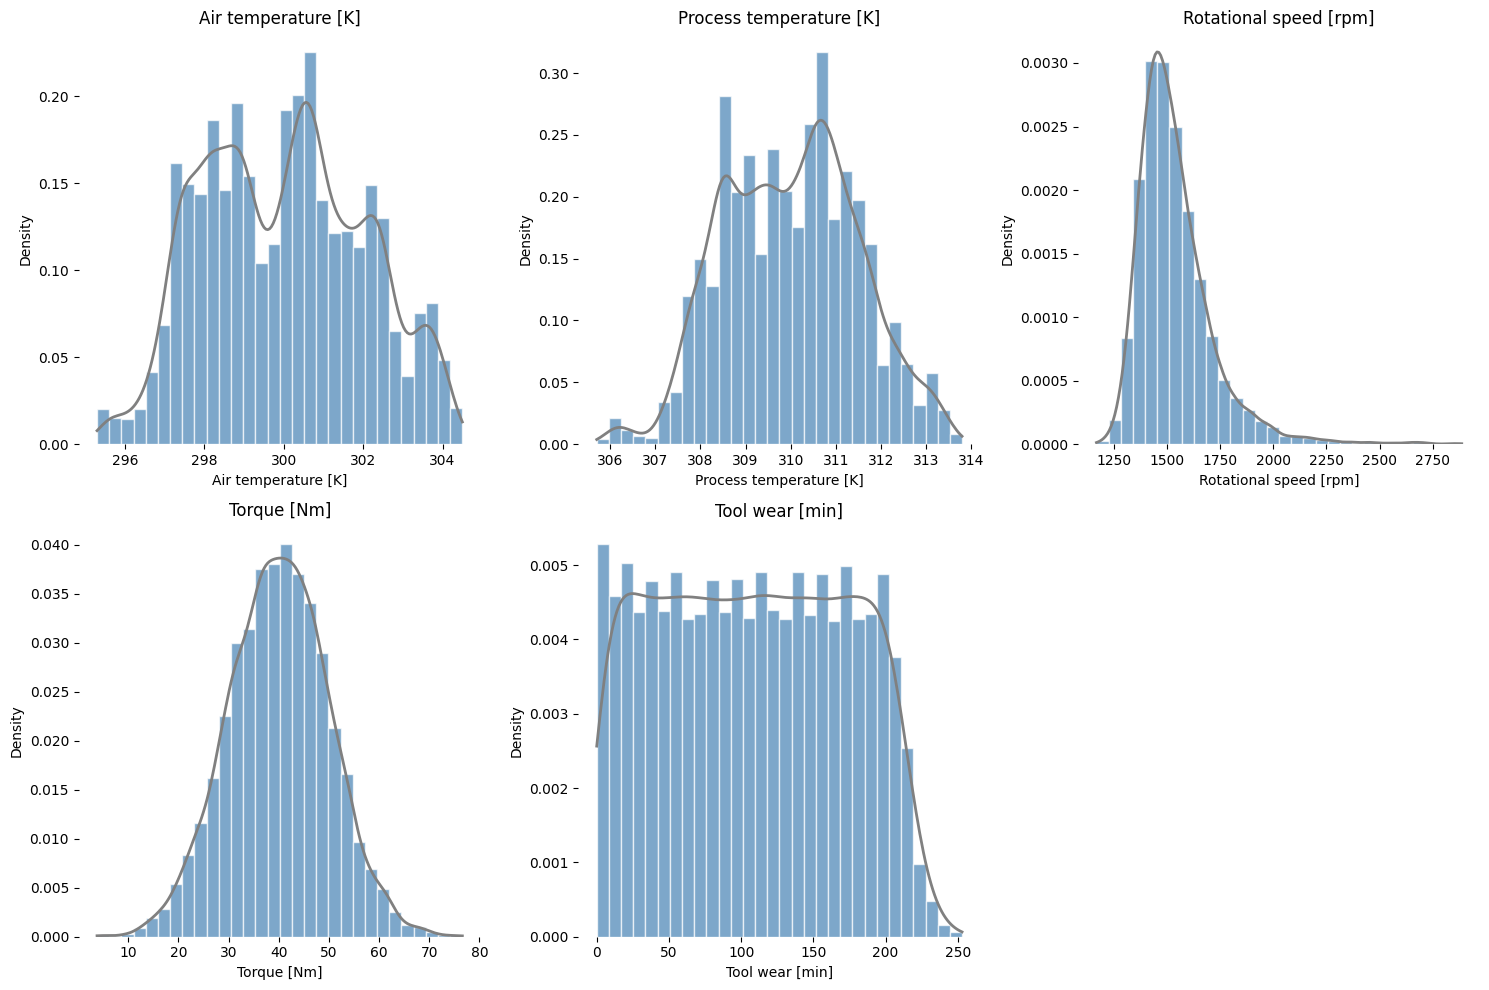

In [10]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(df_predictive_maintenance_numeric, 1):
    plt.subplot(2, 3, i)
    
    plt.hist(df_predictive_maintenance[col], bins=30, density=True, color='steelblue', alpha=0.7, edgecolor='white')

    kde = gaussian_kde(df_predictive_maintenance[col].dropna())
    x_vals = np.linspace(df_predictive_maintenance[col].min(), df_predictive_maintenance[col].max(), 200)
    plt.plot(x_vals, kde(x_vals), color="gray", linewidth=2)
    
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.title(col)
    
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()

### Distribution of Category - `Type`

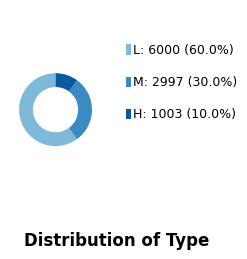

In [11]:
rows, cols = 2, 4
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(rows, cols, figure=fig, wspace=0.6, hspace=0.9)

for idx, col in enumerate(df_predictive_maintenance_category):
    r, c = divmod(idx, cols)

    cell = gs[r, c].subgridspec(
        2, 2,
        height_ratios=[12, 1],
        width_ratios=[3.0, 3.4]
    )
    ax_pie   = fig.add_subplot(cell[0, 0])
    ax_leg   = fig.add_subplot(cell[0, 1])
    ax_title = fig.add_subplot(cell[1, :])

    vals = df_predictive_maintenance[col].value_counts()
    labels = vals.index.to_list()
    sizes  = vals.values
    total  = sizes.sum()

    cmap   = plt.get_cmap("Blues")
    colors = cmap(np.linspace(0.45, 0.85, len(vals)))

    ax_pie.pie(
        sizes, startangle=90, colors=colors,
        wedgeprops=dict(width=0.38), labels=None
    )
    ax_pie.set_aspect('equal')
    ax_pie.set_xticks([]); ax_pie.set_yticks([])

    ax_leg.set_xlim(0, 1); ax_leg.set_ylim(0, 1)
    ax_leg.axis('off')

    n = len(labels)
    y_top = 0.80
    dy = min(0.16, 0.9 / (n + 1))

    for i, (lab, cnt, color) in enumerate(zip(labels, sizes, colors)):
        y = y_top - i * dy

        ax_leg.add_patch(Rectangle((0.05, y - 0.025), 0.05, 0.05, facecolor=color, edgecolor='none'))

        ax_leg.text(0.12, y, f"{lab}: {cnt} ({cnt/total:.1%})",
                    va='center', ha='left', fontsize=9)

    ax_title.axis('off')
    ax_title.text(0.5, 0.5, f"Distribution of {col}",
                  ha='center', va='center', fontsize=12, fontweight='bold')

plt.show()

### Distribution of Target 1 -  `Target`

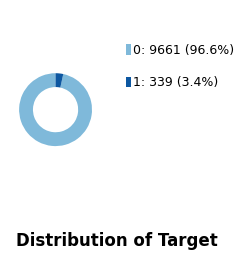

In [12]:
rows, cols = 2, 4
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(rows, cols, figure=fig, wspace=0.6, hspace=0.9)

for idx, col in enumerate(df_predictive_maintenance_target[0:1]):
    r, c = divmod(idx, cols)

    cell = gs[r, c].subgridspec(
        2, 2,
        height_ratios=[12, 1],
        width_ratios=[3.0, 3.4]
    )
    ax_pie   = fig.add_subplot(cell[0, 0])
    ax_leg   = fig.add_subplot(cell[0, 1])
    ax_title = fig.add_subplot(cell[1, :])

    vals = df_predictive_maintenance[col].value_counts()
    labels = vals.index.to_list()
    sizes  = vals.values
    total  = sizes.sum()

    cmap   = plt.get_cmap("Blues")
    colors = cmap(np.linspace(0.45, 0.85, len(vals)))

    ax_pie.pie(
        sizes, startangle=90, colors=colors,
        wedgeprops=dict(width=0.38), labels=None
    )
    ax_pie.set_aspect('equal')
    ax_pie.set_xticks([]); ax_pie.set_yticks([])

    ax_leg.set_xlim(0, 1); ax_leg.set_ylim(0, 1)
    ax_leg.axis('off')

    n = len(labels)
    y_top = 0.80
    dy = min(0.16, 0.9 / (n + 1))

    for i, (lab, cnt, color) in enumerate(zip(labels, sizes, colors)):
        y = y_top - i * dy

        ax_leg.add_patch(Rectangle((0.05, y - 0.025), 0.05, 0.05, facecolor=color, edgecolor='none'))

        ax_leg.text(0.12, y, f"{lab}: {cnt} ({cnt/total:.1%})",
                    va='center', ha='left', fontsize=9)

    ax_title.axis('off')
    ax_title.text(0.5, 0.5, f"Distribution of {col}",
                  ha='center', va='center', fontsize=12, fontweight='bold')

plt.show()

### Distribution of Target 2 - `Failure Type`

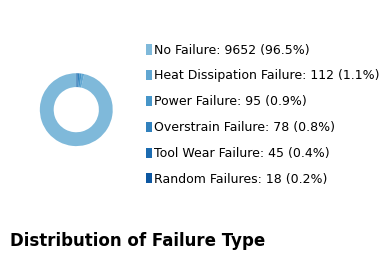

In [13]:
rows, cols = 2, 4
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(rows, cols, figure=fig, wspace=0.6, hspace=0.9)

for idx, col in enumerate(df_predictive_maintenance_target[1:2]):
    r, c = divmod(idx, cols)

    cell = gs[r, c].subgridspec(
        2, 2,
        height_ratios=[12, 1],
        width_ratios=[3.0, 3.4]
    )
    ax_pie   = fig.add_subplot(cell[0, 0])
    ax_leg   = fig.add_subplot(cell[0, 1])
    ax_title = fig.add_subplot(cell[1, :])

    vals = df_predictive_maintenance[col].value_counts()
    labels = vals.index.to_list()
    sizes  = vals.values
    total  = sizes.sum()

    cmap   = plt.get_cmap("Blues")
    colors = cmap(np.linspace(0.45, 0.85, len(vals)))

    ax_pie.pie(
        sizes, startangle=90, colors=colors,
        wedgeprops=dict(width=0.38), labels=None
    )
    ax_pie.set_aspect('equal')
    ax_pie.set_xticks([]); ax_pie.set_yticks([])

    ax_leg.set_xlim(0, 1); ax_leg.set_ylim(0, 1)
    ax_leg.axis('off')

    n = len(labels)
    y_top = 0.80
    dy = min(0.16, 0.9 / (n + 1))

    for i, (lab, cnt, color) in enumerate(zip(labels, sizes, colors)):
        y = y_top - i * dy

        ax_leg.add_patch(Rectangle((0.05, y - 0.025), 0.05, 0.05, facecolor=color, edgecolor='none'))

        ax_leg.text(0.12, y, f"{lab}: {cnt} ({cnt/total:.1%})",
                    va='center', ha='left', fontsize=9)

    ax_title.axis('off')
    ax_title.text(0.5, 0.5, f"Distribution of {col}",
                  ha='center', va='center', fontsize=12, fontweight='bold')

plt.show()

## Expl(ora/ana)tory Data Analysis - Equipment Anomaly Dataset

### Assessing Dataset

In [14]:
assess_dataframe(df_equipment_anomaly, target=df_equipment_anomaly_target[0])

Data Assessment Report

Shape of Dataset: 7672 Rows x 7 Columns

Column Information:
            DataType  Non-Null Count  Null Count  Null %  Unique Values  \
temperature  float64            7672           0     0.0           7672   
pressure     float64            7672           0     0.0           7672   
vibration    float64            7672           0     0.0           7672   
humidity     float64            7672           0     0.0           7672   
equipment     object            7672           0     0.0              3   
location      object            7672           0     0.0              5   
faulty       float64            7672           0     0.0              2   

             Unique %  
temperature    100.00  
pressure       100.00  
vibration      100.00  
humidity       100.00  
equipment        0.04  
location         0.07  
faulty           0.03  

Duplicate Rows: 0 (0.0%)

Constant Columns:
None

High Cardinality Categorical Columns (>= 50% Unique):
None

Numeric Col

### Histogram & KDE of Numeric Features

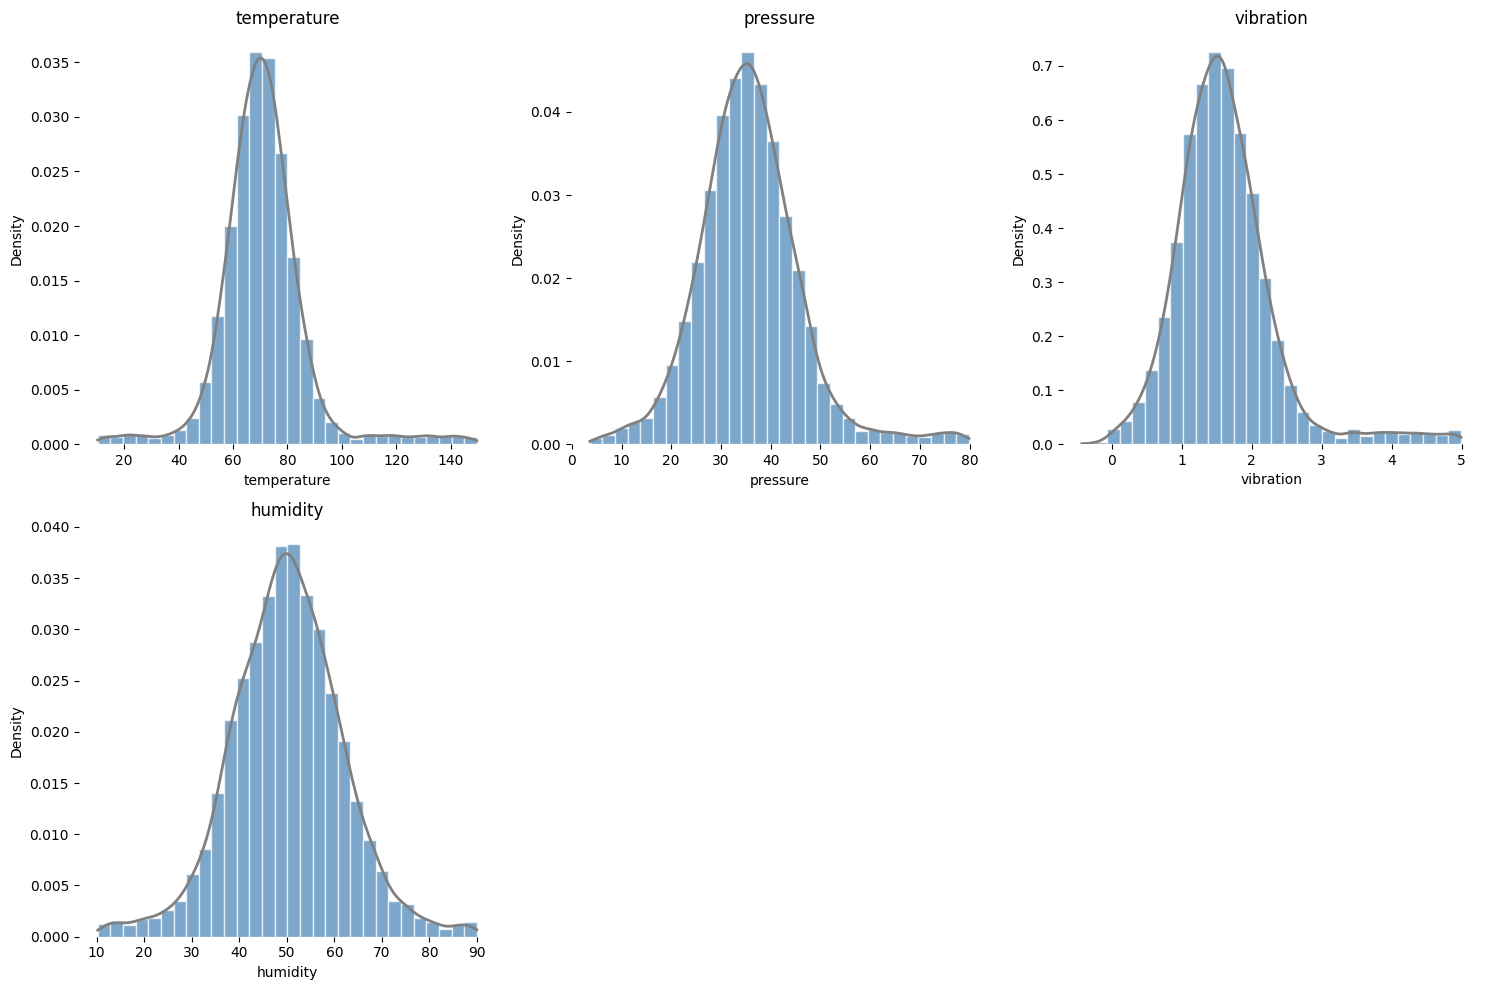

In [15]:
plt.figure(figsize=(15, 10))

for i, col in enumerate(df_equipment_anomaly_numeric, 1):
    plt.subplot(2, 3, i)

    plt.hist(df_equipment_anomaly[col], bins=30, density=True, color='steelblue', alpha=0.7, edgecolor='white')

    kde = gaussian_kde(df_equipment_anomaly[col].dropna())
    x_vals = np.linspace(df_equipment_anomaly[col].min(), df_equipment_anomaly[col].max(), 200)
    plt.plot(x_vals, kde(x_vals), color="gray", linewidth=2)
    
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.title(col)
    
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()

### Distribution of Category - `equipment`, `location`

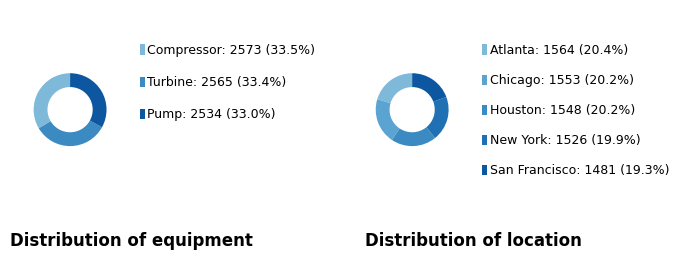

In [16]:
rows, cols = 2, 4
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(rows, cols, figure=fig, wspace=0.6, hspace=0.9)

for idx, col in enumerate(df_equipment_anomaly_category):
    r, c = divmod(idx, cols)

    cell = gs[r, c].subgridspec(
        2, 2,
        height_ratios=[12, 1],
        width_ratios=[3.0, 3.4]
    )
    ax_pie   = fig.add_subplot(cell[0, 0])
    ax_leg   = fig.add_subplot(cell[0, 1])
    ax_title = fig.add_subplot(cell[1, :])

    vals = df_equipment_anomaly[col].value_counts()
    labels = vals.index.to_list()
    sizes  = vals.values
    total  = sizes.sum()

    cmap   = plt.get_cmap("Blues")
    colors = cmap(np.linspace(0.45, 0.85, len(vals)))

    ax_pie.pie(
        sizes, startangle=90, colors=colors,
        wedgeprops=dict(width=0.38), labels=None
    )
    ax_pie.set_aspect('equal')
    ax_pie.set_xticks([]); ax_pie.set_yticks([])

    ax_leg.set_xlim(0, 1); ax_leg.set_ylim(0, 1)
    ax_leg.axis('off')

    n = len(labels)
    y_top = 0.80
    dy = min(0.16, 0.9 / (n + 1))

    for i, (lab, cnt, color) in enumerate(zip(labels, sizes, colors)):
        y = y_top - i * dy

        ax_leg.add_patch(Rectangle((0.05, y - 0.025), 0.05, 0.05, facecolor=color, edgecolor='none'))

        ax_leg.text(0.12, y, f"{lab}: {cnt} ({cnt/total:.1%})",
                    va='center', ha='left', fontsize=9)

    ax_title.axis('off')
    ax_title.text(0.5, 0.5, f"Distribution of {col}",
                  ha='center', va='center', fontsize=12, fontweight='bold')

plt.show()

### Distribution of Target - `faulty`

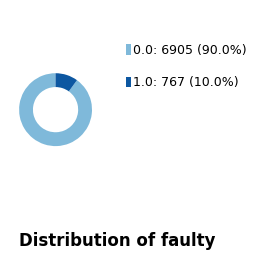

In [17]:
rows, cols = 2, 4
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(rows, cols, figure=fig, wspace=0.6, hspace=0.9)

for idx, col in enumerate(df_equipment_anomaly_target):
    r, c = divmod(idx, cols)

    cell = gs[r, c].subgridspec(
        2, 2,
        height_ratios=[12, 1],
        width_ratios=[3.0, 3.4]
    )
    ax_pie   = fig.add_subplot(cell[0, 0])
    ax_leg   = fig.add_subplot(cell[0, 1])
    ax_title = fig.add_subplot(cell[1, :])

    vals = df_equipment_anomaly[col].value_counts()
    labels = vals.index.to_list()
    sizes  = vals.values
    total  = sizes.sum()

    cmap   = plt.get_cmap("Blues")
    colors = cmap(np.linspace(0.45, 0.85, len(vals)))

    ax_pie.pie(
        sizes, startangle=90, colors=colors,
        wedgeprops=dict(width=0.38), labels=None
    )
    ax_pie.set_aspect('equal')
    ax_pie.set_xticks([]); ax_pie.set_yticks([])

    ax_leg.set_xlim(0, 1); ax_leg.set_ylim(0, 1)
    ax_leg.axis('off')

    n = len(labels)
    y_top = 0.80
    dy = min(0.16, 0.9 / (n + 1))

    for i, (lab, cnt, color) in enumerate(zip(labels, sizes, colors)):
        y = y_top - i * dy

        ax_leg.add_patch(Rectangle((0.05, y - 0.025), 0.05, 0.05, facecolor=color, edgecolor='none'))

        ax_leg.text(0.12, y, f"{lab}: {cnt} ({cnt/total:.1%})",
                    va='center', ha='left', fontsize=9)

    ax_title.axis('off')
    ax_title.text(0.5, 0.5, f"Distribution of {col}",
                  ha='center', va='center', fontsize=12, fontweight='bold')

plt.show()

## Expl(ora/ana)tory Data Analysis - Marine Engine Dataset

### Assessing Dataset with Different Target

In [18]:
assess_dataframe(df_marine_engine, target=df_marine_engine_target[0])

Data Assessment Report

Shape of Dataset: 5200 Rows x 17 Columns

Column Information:
                          DataType  Non-Null Count  Null Count  Null %  \
timestamp                   object            5200           0     0.0   
engine_id                   object            5200           0     0.0   
engine_temp                float64            5200           0     0.0   
oil_pressure               float64            5200           0     0.0   
fuel_consumption           float64            5200           0     0.0   
vibration_level            float64            5200           0     0.0   
rpm                        float64            5200           0     0.0   
engine_load                float64            5200           0     0.0   
coolant_temp               float64            5200           0     0.0   
exhaust_temp               float64            5200           0     0.0   
running_period             float64            5200           0     0.0   
fuel_consumption_per_hour 

In [19]:
assess_dataframe(df_marine_engine, target=df_marine_engine_target[1])

Data Assessment Report

Shape of Dataset: 5200 Rows x 17 Columns

Column Information:
                          DataType  Non-Null Count  Null Count  Null %  \
timestamp                   object            5200           0     0.0   
engine_id                   object            5200           0     0.0   
engine_temp                float64            5200           0     0.0   
oil_pressure               float64            5200           0     0.0   
fuel_consumption           float64            5200           0     0.0   
vibration_level            float64            5200           0     0.0   
rpm                        float64            5200           0     0.0   
engine_load                float64            5200           0     0.0   
coolant_temp               float64            5200           0     0.0   
exhaust_temp               float64            5200           0     0.0   
running_period             float64            5200           0     0.0   
fuel_consumption_per_hour 

### Histogram & KDE Numeric Features

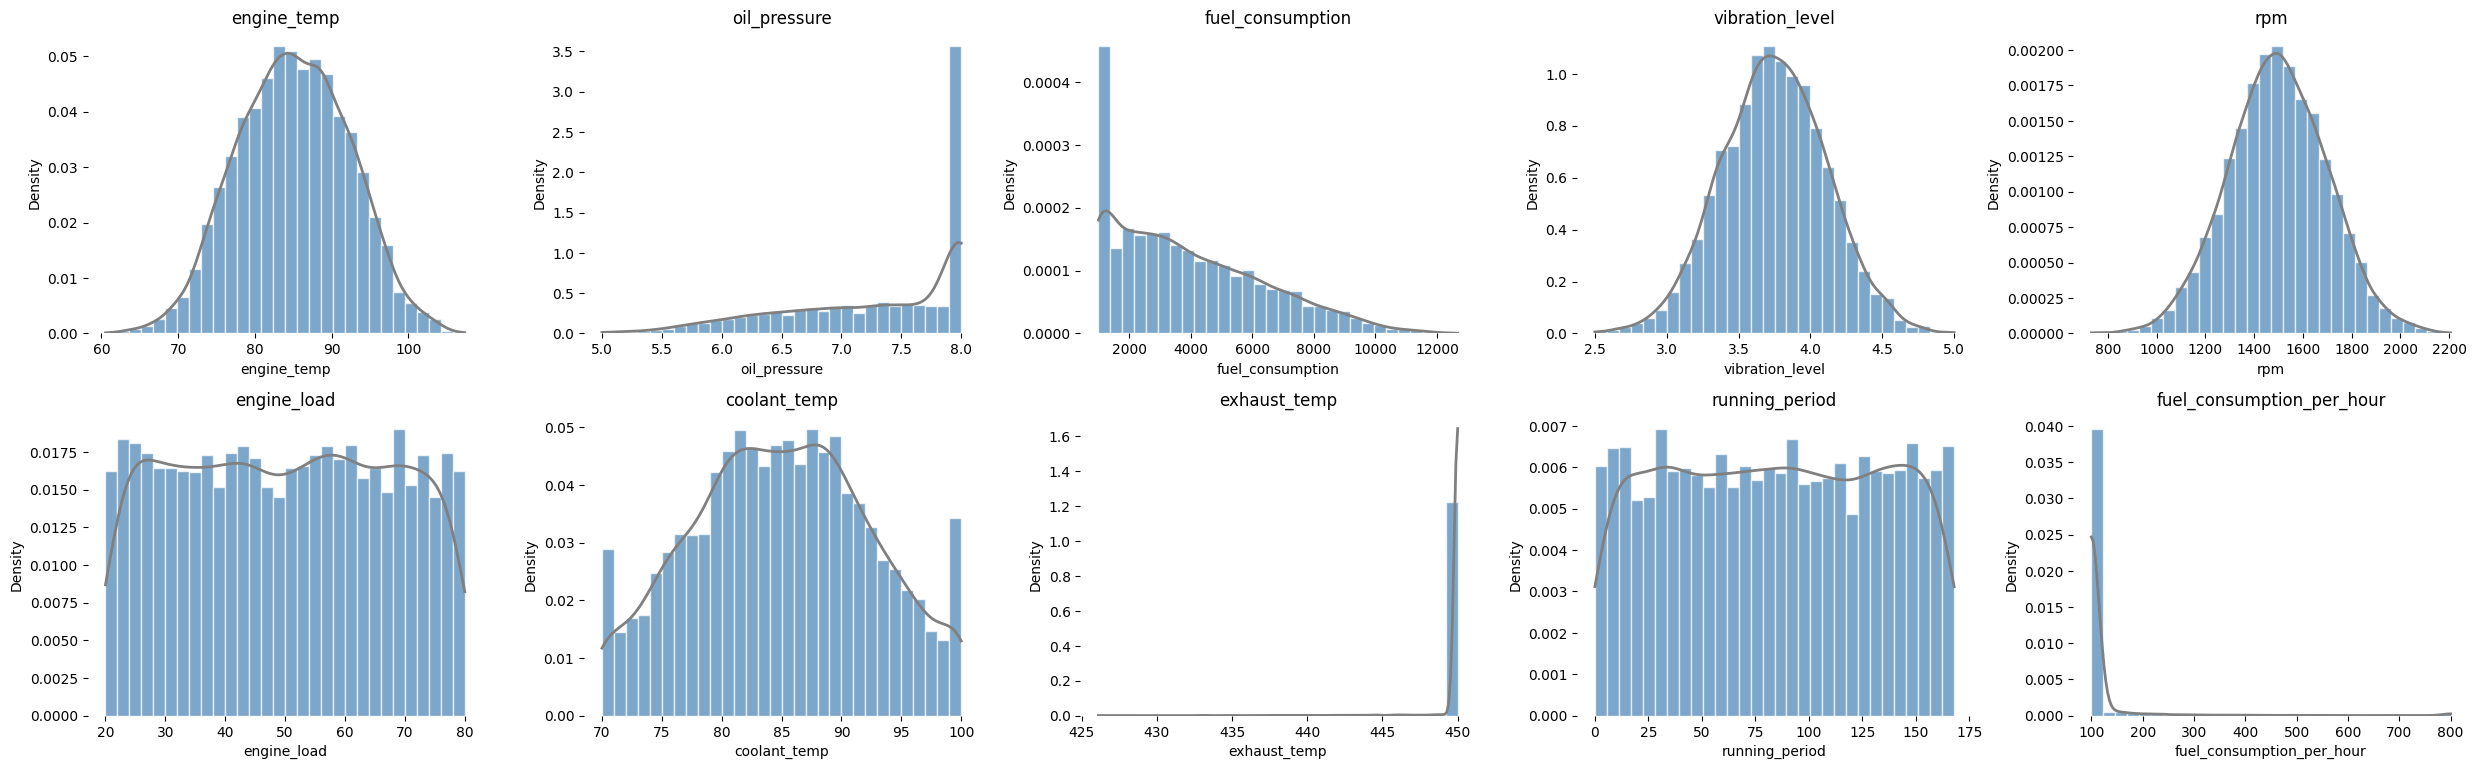

In [20]:

plt.figure(figsize=(25, 15))

for i, col in enumerate(df_marine_engine_numeric, 1):
    plt.subplot(4, 5, i)

    plt.hist(df_marine_engine[col], bins=30, density=True, color='steelblue', alpha=0.7, edgecolor='white')

    kde = gaussian_kde(df_marine_engine[col].dropna())
    x_vals = np.linspace(df_marine_engine[col].min(), df_marine_engine[col].max(), 200)
    plt.plot(x_vals, kde(x_vals), color="gray", linewidth=2)
    
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.title(col)
    
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_visible(False)

plt.tight_layout()
plt.show()

### Distribution of Category - `fuel_type`, `engine_type`, `manufacturer`

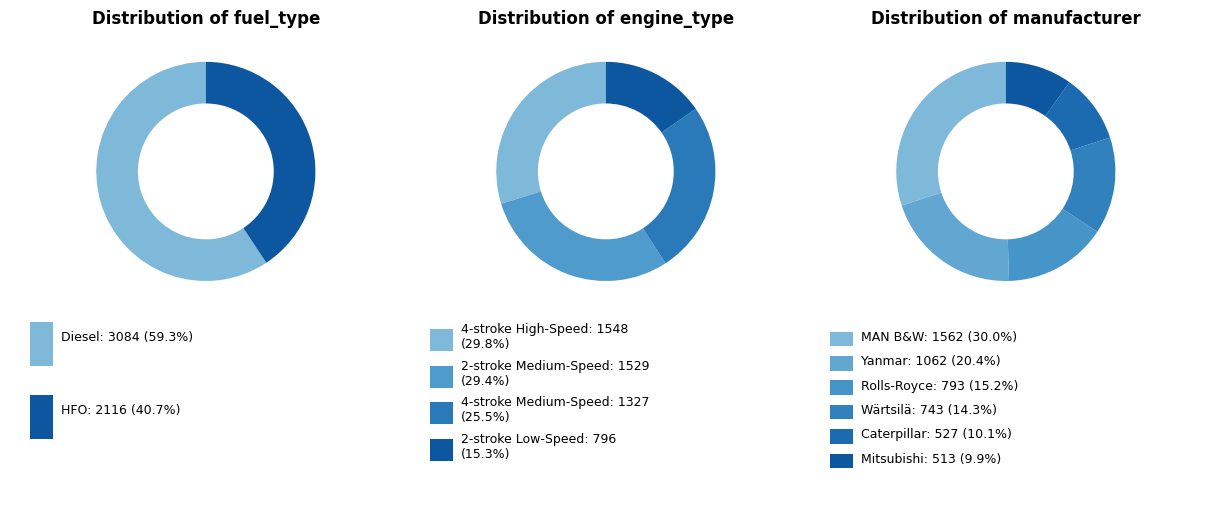

In [ ]:
rows, cols = 2, 4
fig = plt.figure(figsize=(16, 10), layout='constrained')
gs = GridSpec(rows, cols, figure=fig)

WRAP_WIDTH_BASE = 28
LEG_FONTSIZE = 9
COLOR_BOX_W = 0.06
X_PAD = 0.02

for idx, col in enumerate(df_marine_engine_category):
    r, c = divmod(idx, cols)

    # 2x1 inner grid: pie on top (spans full width), legend below (full width)
    cell = gs[r, c].subgridspec(2, 1, height_ratios=[3.0, 2.0])
    ax_pie = fig.add_subplot(cell[0, 0])
    ax_leg = fig.add_subplot(cell[1, 0])

    # data
    vals   = df_marine_engine[col].value_counts()
    labels = vals.index.to_list()
    sizes  = vals.values
    total  = sizes.sum()

    # colors
    cmap   = plt.get_cmap("Blues")
    colors = cmap(np.linspace(0.45, 0.85, len(vals)))

    # donut
    ax_pie.pie(
        sizes, startangle=90, colors=colors,
        wedgeprops=dict(width=0.38), labels=None, normalize=True
    )
    ax_pie.set_aspect('equal', adjustable='box')
    ax_pie.set_title(f"Distribution of {col}", fontsize=12, fontweight='bold', pad=8)
    ax_pie.set_xticks([]); ax_pie.set_yticks([])

    # legend (full-width band)
    ax_leg.set_xlim(0, 1); ax_leg.set_ylim(0, 1)
    ax_leg.axis('off')

    n = len(labels)
    # adaptive columns (more robust with full width)
    if   n <= 6:  ncols_leg = 1
    elif n <= 12: ncols_leg = 2
    else:         ncols_leg = 3

    nrows_leg = int(np.ceil(n / ncols_leg))

    top_margin = 0.90
    bot_margin = 0.10
    dy = (top_margin - bot_margin) / max(nrows_leg, 1)

    x_min, x_max = 0.05, 0.95
    col_width = (x_max - x_min) / ncols_leg

    WRAP_WIDTH = max(12, int(WRAP_WIDTH_BASE * (1.0 / ncols_leg)))

    for i, (lab, cnt, color) in enumerate(zip(labels, sizes, colors)):
        col_id = i // nrows_leg
        row_id = i %  nrows_leg

        x_left_slot = x_min + col_id * col_width
        y = top_margin - row_id * dy

        # color box (clipped)
        ax_leg.add_patch(
            Rectangle((x_left_slot, y - 0.5*dy + 0.5*dy*0.2), COLOR_BOX_W, dy*0.6,
                      facecolor=color, edgecolor='none', transform=ax_leg.transAxes,
                      clip_on=True)
        )

        pct = cnt / total
        text = textwrap.fill(f"{lab}: {cnt} ({pct:.1%})", width=WRAP_WIDTH)

        ax_leg.text(x_left_slot + COLOR_BOX_W + X_PAD, y, text,
                    va='center', ha='left', fontsize=LEG_FONTSIZE,
                    transform=ax_leg.transAxes, clip_on=True)

plt.show()

### Distribution of Target - `maintenance_status`

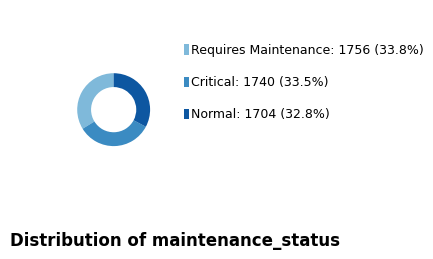

In [22]:
rows, cols = 2, 4
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(rows, cols, figure=fig, wspace=0.6, hspace=0.9)

for idx, col in enumerate(df_marine_engine_target[0:1]):
    r, c = divmod(idx, cols)

    cell = gs[r, c].subgridspec(
        2, 2,
        height_ratios=[12, 1],
        width_ratios=[3.0, 3.4]
    )
    ax_pie   = fig.add_subplot(cell[0, 0])
    ax_leg   = fig.add_subplot(cell[0, 1])
    ax_title = fig.add_subplot(cell[1, :])

    vals = df_marine_engine[col].value_counts()
    labels = vals.index.to_list()
    sizes  = vals.values
    total  = sizes.sum()

    cmap   = plt.get_cmap("Blues")
    colors = cmap(np.linspace(0.45, 0.85, len(vals)))

    ax_pie.pie(
        sizes, startangle=90, colors=colors,
        wedgeprops=dict(width=0.38), labels=None
    )
    ax_pie.set_aspect('equal')
    ax_pie.set_xticks([]); ax_pie.set_yticks([])

    ax_leg.set_xlim(0, 1); ax_leg.set_ylim(0, 1)
    ax_leg.axis('off')

    n = len(labels)
    y_top = 0.80
    dy = min(0.16, 0.9 / (n + 1))

    for i, (lab, cnt, color) in enumerate(zip(labels, sizes, colors)):
        y = y_top - i * dy

        ax_leg.add_patch(Rectangle((0.05, y - 0.025), 0.05, 0.05, facecolor=color, edgecolor='none'))

        ax_leg.text(0.12, y, f"{lab}: {cnt} ({cnt/total:.1%})",
                    va='center', ha='left', fontsize=9)

    ax_title.axis('off')
    ax_title.text(0.5, 0.5, f"Distribution of {col}",
                  ha='center', va='center', fontsize=12, fontweight='bold')

plt.show()

### Distribution of Target - `failure_mode`

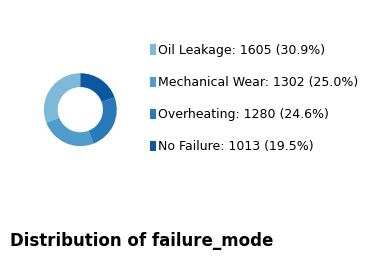

In [23]:
rows, cols = 2, 4
fig = plt.figure(figsize=(16, 9))
gs = GridSpec(rows, cols, figure=fig, wspace=0.6, hspace=0.9)

for idx, col in enumerate(df_marine_engine_target[1:2]):
    r, c = divmod(idx, cols)

    cell = gs[r, c].subgridspec(
        2, 2,
        height_ratios=[12, 1],
        width_ratios=[3.0, 3.4]
    )
    ax_pie   = fig.add_subplot(cell[0, 0])
    ax_leg   = fig.add_subplot(cell[0, 1])
    ax_title = fig.add_subplot(cell[1, :])

    vals = df_marine_engine[col].value_counts()
    labels = vals.index.to_list()
    sizes  = vals.values
    total  = sizes.sum()

    cmap   = plt.get_cmap("Blues")
    colors = cmap(np.linspace(0.45, 0.85, len(vals)))

    ax_pie.pie(
        sizes, startangle=90, colors=colors,
        wedgeprops=dict(width=0.38), labels=None
    )
    ax_pie.set_aspect('equal')
    ax_pie.set_xticks([]); ax_pie.set_yticks([])

    ax_leg.set_xlim(0, 1); ax_leg.set_ylim(0, 1)
    ax_leg.axis('off')

    n = len(labels)
    y_top = 0.80
    dy = min(0.16, 0.9 / (n + 1))

    for i, (lab, cnt, color) in enumerate(zip(labels, sizes, colors)):
        y = y_top - i * dy

        ax_leg.add_patch(Rectangle((0.05, y - 0.025), 0.05, 0.05, facecolor=color, edgecolor='none'))

        ax_leg.text(0.12, y, f"{lab}: {cnt} ({cnt/total:.1%})",
                    va='center', ha='left', fontsize=9)

    ax_title.axis('off')
    ax_title.text(0.5, 0.5, f"Distribution of {col}",
                  ha='center', va='center', fontsize=12, fontweight='bold')

plt.show()

### Visualization of `timestamp` vs Numeric Features (Monthly)

C:\Users\Rahfi\AppData\Local\Temp\ipykernel_5116\4170249388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = df_ts[col].resample("M").agg(["mean", "median", "min", "max"]).dropna()


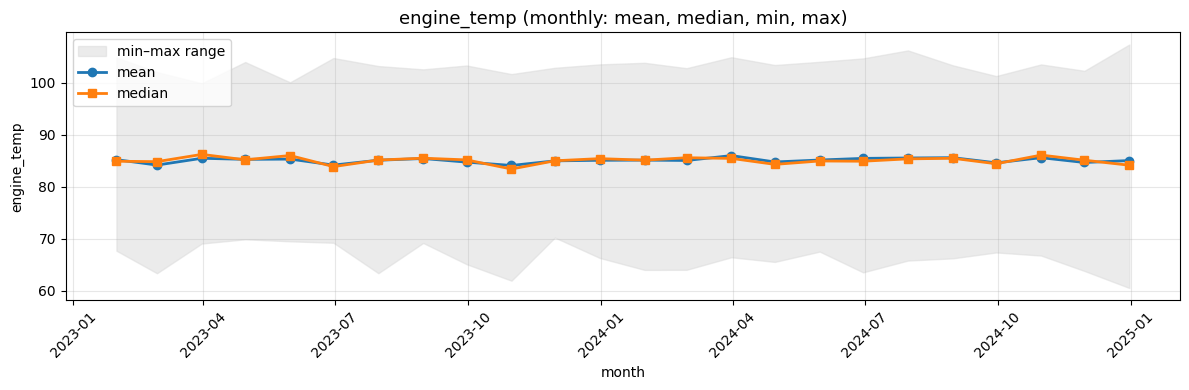

C:\Users\Rahfi\AppData\Local\Temp\ipykernel_5116\4170249388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = df_ts[col].resample("M").agg(["mean", "median", "min", "max"]).dropna()


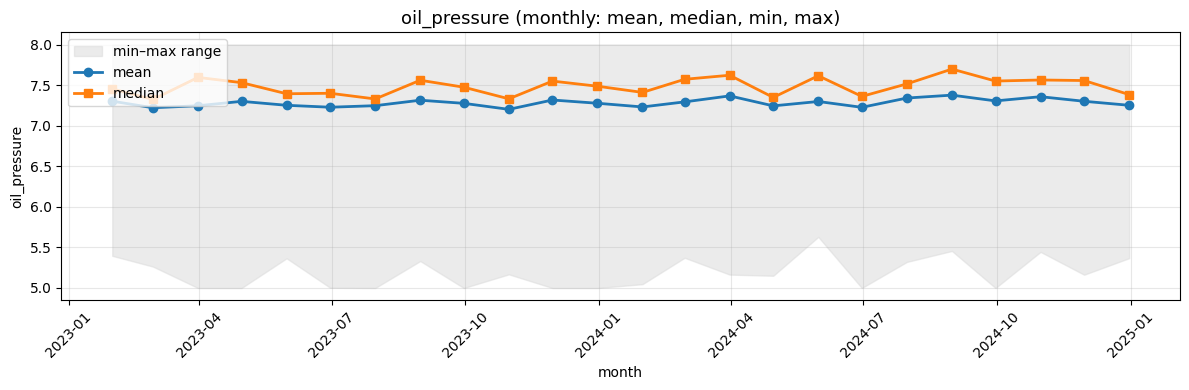

C:\Users\Rahfi\AppData\Local\Temp\ipykernel_5116\4170249388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = df_ts[col].resample("M").agg(["mean", "median", "min", "max"]).dropna()


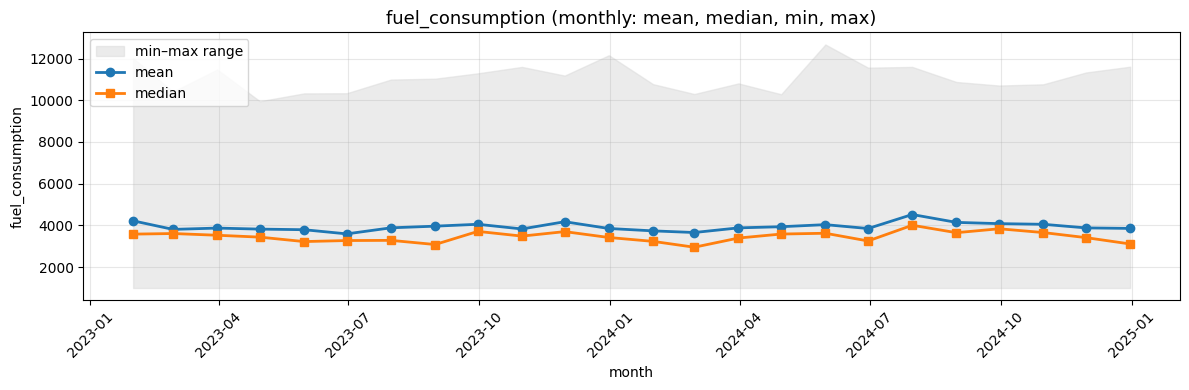

C:\Users\Rahfi\AppData\Local\Temp\ipykernel_5116\4170249388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = df_ts[col].resample("M").agg(["mean", "median", "min", "max"]).dropna()


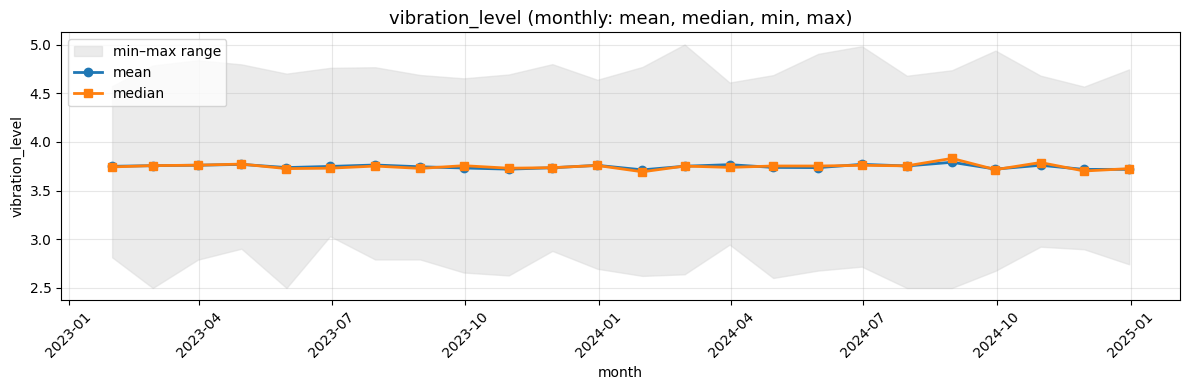

C:\Users\Rahfi\AppData\Local\Temp\ipykernel_5116\4170249388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = df_ts[col].resample("M").agg(["mean", "median", "min", "max"]).dropna()


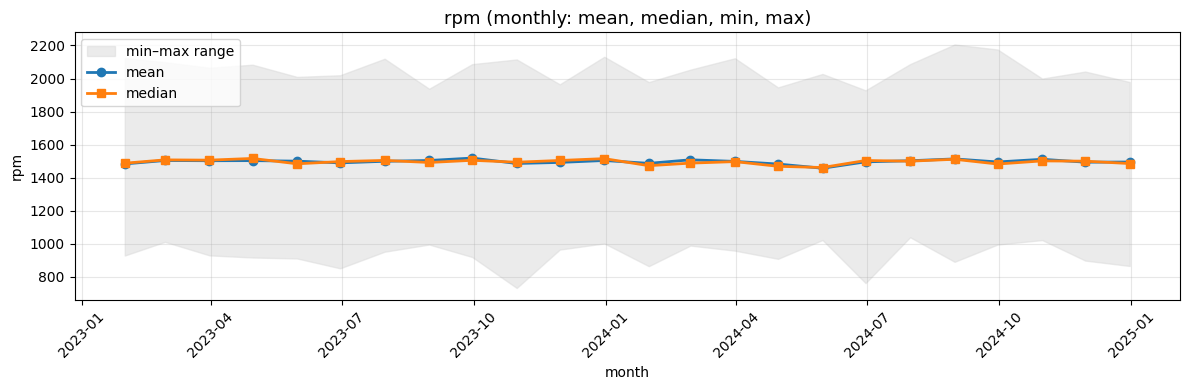

C:\Users\Rahfi\AppData\Local\Temp\ipykernel_5116\4170249388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = df_ts[col].resample("M").agg(["mean", "median", "min", "max"]).dropna()


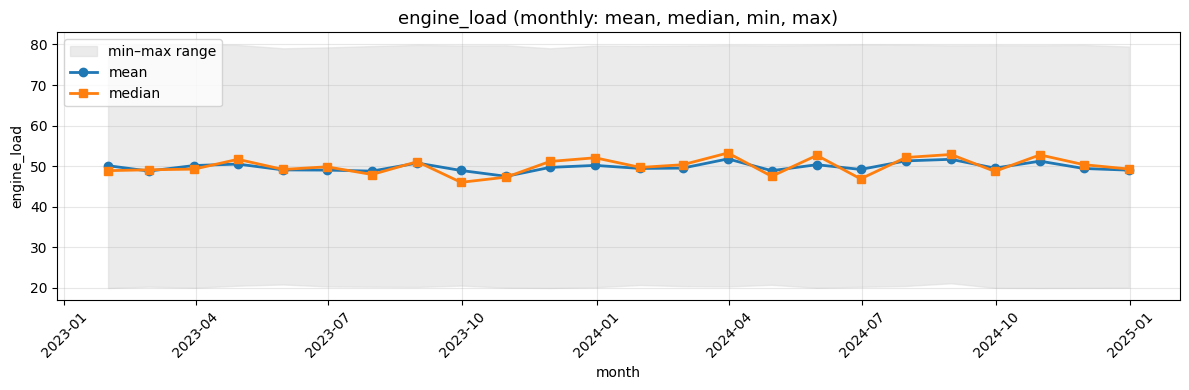

C:\Users\Rahfi\AppData\Local\Temp\ipykernel_5116\4170249388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = df_ts[col].resample("M").agg(["mean", "median", "min", "max"]).dropna()


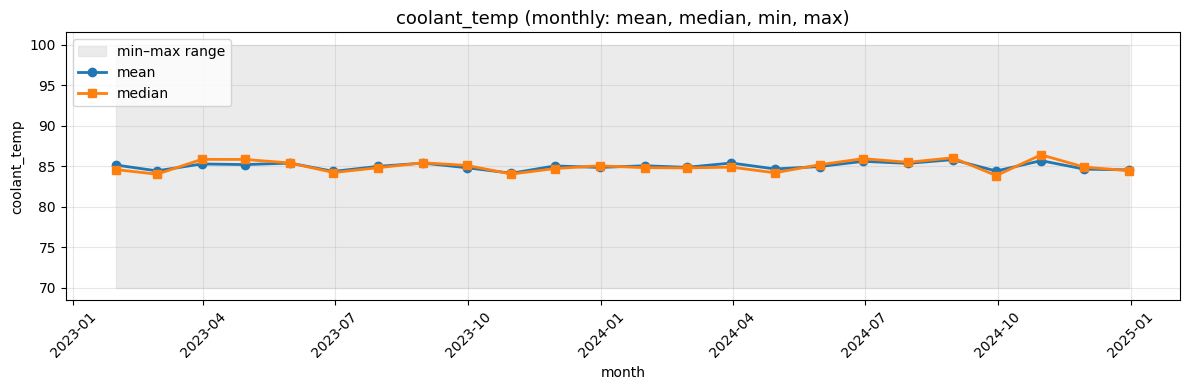

C:\Users\Rahfi\AppData\Local\Temp\ipykernel_5116\4170249388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = df_ts[col].resample("M").agg(["mean", "median", "min", "max"]).dropna()


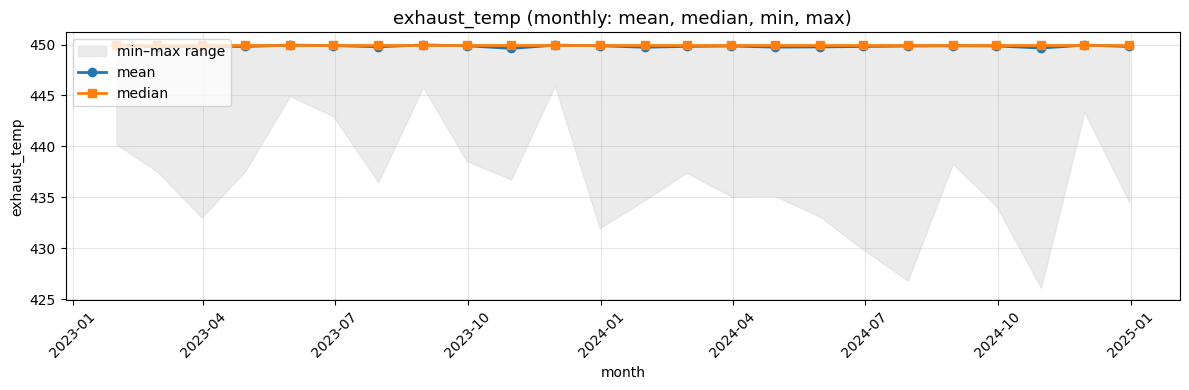

C:\Users\Rahfi\AppData\Local\Temp\ipykernel_5116\4170249388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = df_ts[col].resample("M").agg(["mean", "median", "min", "max"]).dropna()


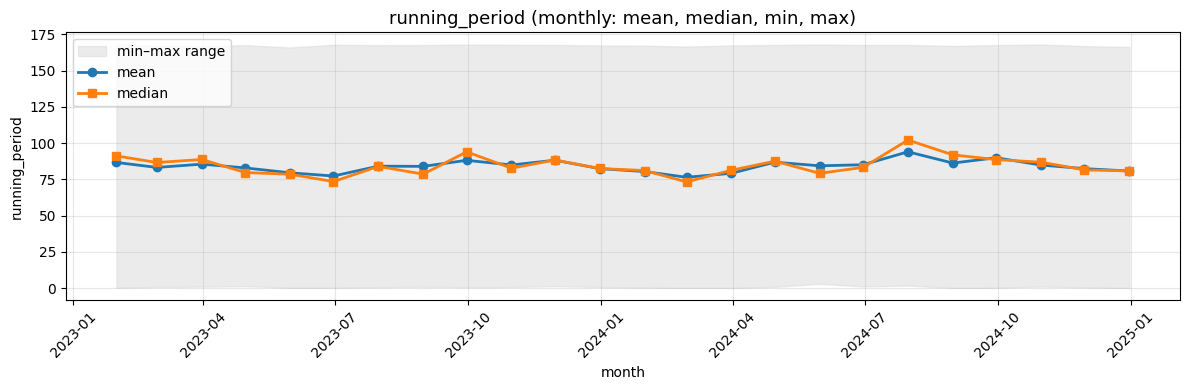

C:\Users\Rahfi\AppData\Local\Temp\ipykernel_5116\4170249388.py:12: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  agg = df_ts[col].resample("M").agg(["mean", "median", "min", "max"]).dropna()


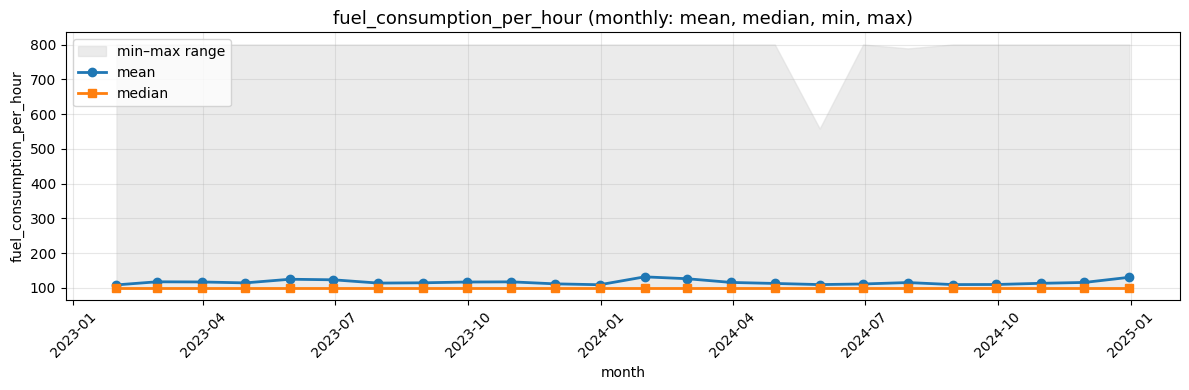

In [ ]:
ts_col = df_marine_engine_timestamp[0]

# Ensure datetime and set as index
df_marine_engine[ts_col] = pd.to_datetime(df_marine_engine[ts_col], errors="coerce")
df_ts = df_marine_engine.set_index(ts_col)

for col in df_marine_engine_numeric:
    if col not in df_ts.columns:
        continue

    # Monthly aggregation
    agg = df_ts[col].resample("M").agg(["mean", "median", "min", "max"]).dropna()

    if agg.empty:
        continue

    # Plot
    plt.figure(figsize=(12, 4))

    # Shaded min–max band
    plt.fill_between(
        agg.index, agg["min"], agg["max"],
        color="#d9d9d9", alpha=0.5, label="min–max range"
    )

    # Mean and median lines
    plt.plot(agg.index, agg["mean"], color="#1f77b4", linewidth=2, marker="o", label="mean")
    plt.plot(agg.index, agg["median"], color="#ff7f0e", linewidth=2, marker="s", label="median")

    # Cosmetics
    plt.title(f"{col} (monthly: mean, median, min, max)", fontsize=13)
    plt.xlabel("month")
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.grid(alpha=0.3)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()


### Visualization of `timestamp` vs Categorical Features (Monthly)

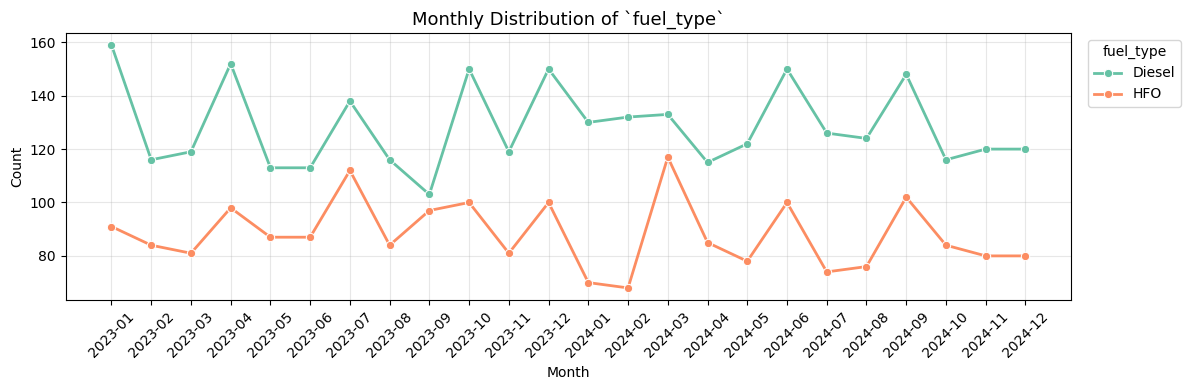

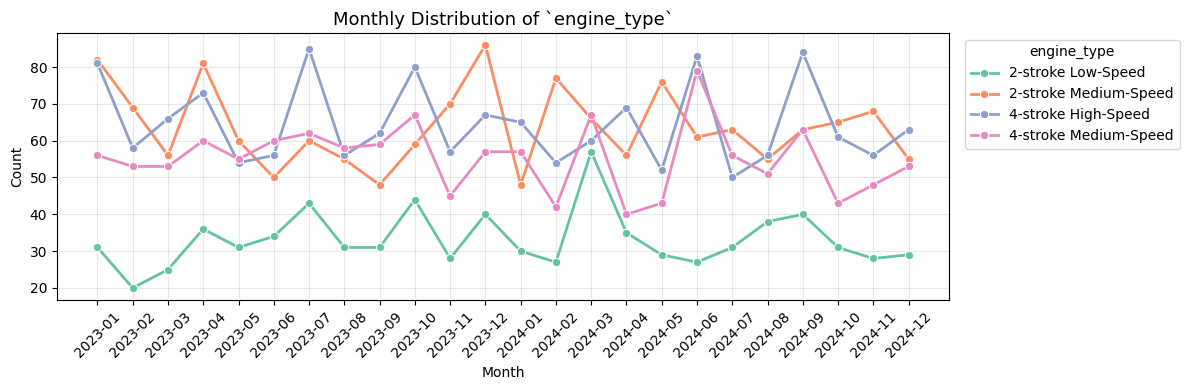

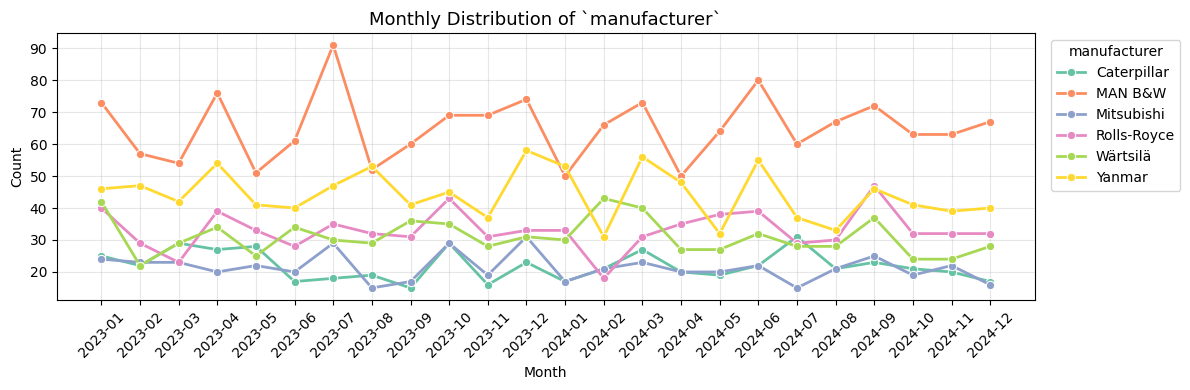

In [25]:
df_marine_engine["month"] = df_marine_engine["timestamp"].dt.to_period("M").astype(str)

sns.set_palette("Set2")

for col in df_marine_engine_category:
    if col == ts_col:
        continue

    # Aggregate counts per month per category
    monthly_counts = (
        df_marine_engine.groupby(["month", col])
        .size()
        .reset_index(name="count")
    )

    plt.figure(figsize=(12, 4))
    sns.lineplot(
        data=monthly_counts,
        x="month",
        y="count",
        hue=col,
        marker="o",
        linewidth=2,
        palette="Set2"
    )

    plt.title(f"Monthly Distribution of `{col}`", fontsize=13)
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title=col, bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


### Visualization of `timestamp` vs Target (Monthly)

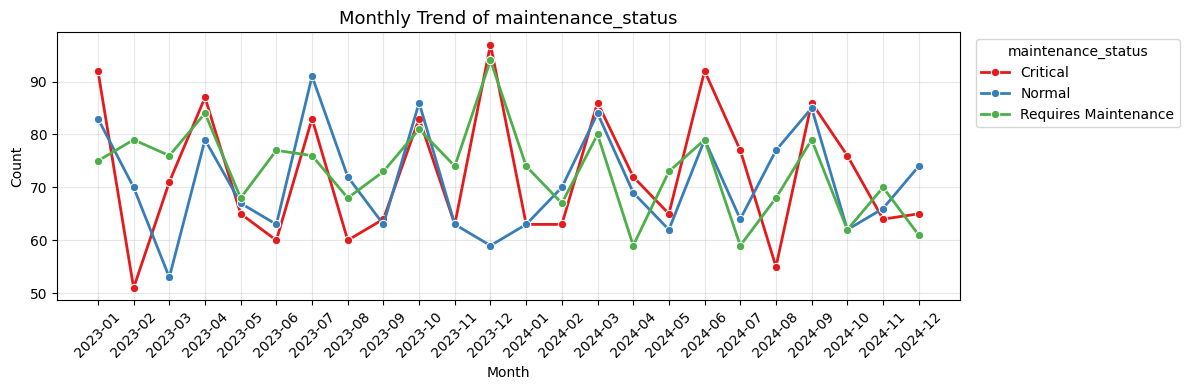

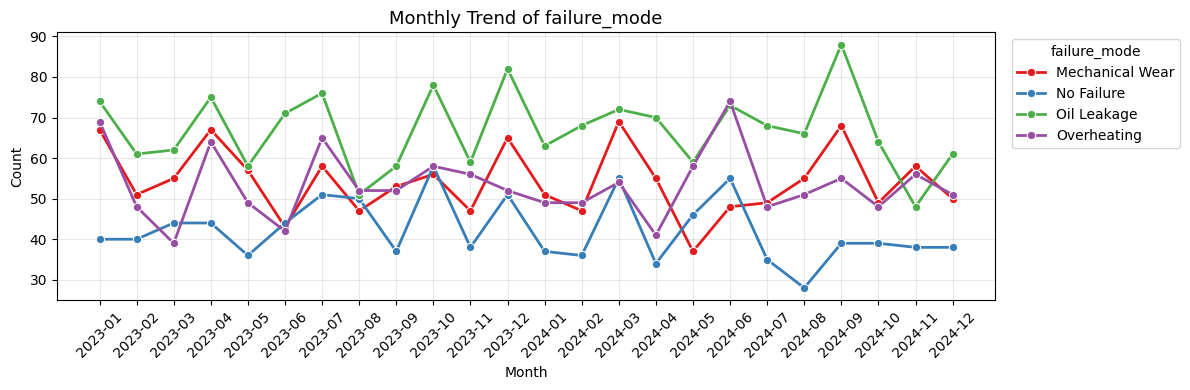

In [26]:
df_marine_engine["month"] = df_marine_engine["timestamp"].dt.to_period("M").astype(str)

for col in df_marine_engine_target:
    # Aggregate: count each category per month
    monthly_counts = (
        df_marine_engine.groupby(["month", col])
        .size()
        .reset_index(name="count")
    )

    # Plot
    plt.figure(figsize=(12, 4))
    sns.lineplot(
        data=monthly_counts,
        x="month",
        y="count",
        hue=col,
        marker="o",
        palette="Set1",
        linewidth=2
    )

    plt.title(f"Monthly Trend of {col}", fontsize=13)
    plt.xlabel("Month")
    plt.ylabel("Count")
    plt.xticks(rotation=45)
    plt.legend(title=col, bbox_to_anchor=(1.01, 1), loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()


## Data Cleaning (No Duplicated, No Missing Cols)

### Dataset - Predictive Maintenance | Need Cleaning - Need Balancing (Imbalanced Dataset)

In [27]:
assess_dataframe(df_predictive_maintenance, target=df_predictive_maintenance_target[0])

Data Assessment Report

Shape of Dataset: 10000 Rows x 10 Columns

Column Information:
                        DataType  Non-Null Count  Null Count  Null %  \
UDI                        int64           10000           0     0.0   
Product ID                object           10000           0     0.0   
Type                      object           10000           0     0.0   
Air temperature [K]      float64           10000           0     0.0   
Process temperature [K]  float64           10000           0     0.0   
Rotational speed [rpm]     int64           10000           0     0.0   
Torque [Nm]              float64           10000           0     0.0   
Tool wear [min]            int64           10000           0     0.0   
Target                     int64           10000           0     0.0   
Failure Type              object           10000           0     0.0   

                         Unique Values  Unique %  
UDI                              10000    100.00  
Product ID        

#### Assessing Dataset with Different Target - `Fail Type`

In [28]:
assess_dataframe(df_predictive_maintenance, target=df_predictive_maintenance_target[1])

Data Assessment Report

Shape of Dataset: 10000 Rows x 10 Columns

Column Information:
                        DataType  Non-Null Count  Null Count  Null %  \
UDI                        int64           10000           0     0.0   
Product ID                object           10000           0     0.0   
Type                      object           10000           0     0.0   
Air temperature [K]      float64           10000           0     0.0   
Process temperature [K]  float64           10000           0     0.0   
Rotational speed [rpm]     int64           10000           0     0.0   
Torque [Nm]              float64           10000           0     0.0   
Tool wear [min]            int64           10000           0     0.0   
Target                     int64           10000           0     0.0   
Failure Type              object           10000           0     0.0   

                         Unique Values  Unique %  
UDI                              10000    100.00  
Product ID        

#### Drop ID - `UDI`, `Product ID`

In [29]:
df_predictive_maintenance = df_predictive_maintenance.drop(columns=df_predictive_maintenance_id)
df_predictive_maintenance.head()

,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Target,Failure Type
0,M,298.1,308.6,1551,42.8,0,0,No Failure
1,L,298.2,308.7,1408,46.3,3,0,No Failure
2,L,298.1,308.5,1498,49.4,5,0,No Failure
3,L,298.2,308.6,1433,39.5,7,0,No Failure
4,L,298.2,308.7,1408,40.0,9,0,No Failure


### Dataset - Equipment Anomaly | Need Balancing (Imbalanced Dataset)

In [30]:
assess_dataframe(df_equipment_anomaly, target=df_equipment_anomaly_target[0])

Data Assessment Report

Shape of Dataset: 7672 Rows x 7 Columns

Column Information:
            DataType  Non-Null Count  Null Count  Null %  Unique Values  \
temperature  float64            7672           0     0.0           7672   
pressure     float64            7672           0     0.0           7672   
vibration    float64            7672           0     0.0           7672   
humidity     float64            7672           0     0.0           7672   
equipment     object            7672           0     0.0              3   
location      object            7672           0     0.0              5   
faulty       float64            7672           0     0.0              2   

             Unique %  
temperature    100.00  
pressure       100.00  
vibration      100.00  
humidity       100.00  
equipment        0.04  
location         0.07  
faulty           0.03  

Duplicate Rows: 0 (0.0%)

Constant Columns:
None

High Cardinality Categorical Columns (>= 50% Unique):
None

Numeric Col

### Dataset - Maringe Engine | Need Cleaning

In [31]:
assess_dataframe(df_marine_engine, target=df_marine_engine_target[0])

Data Assessment Report

Shape of Dataset: 5200 Rows x 18 Columns

Column Information:
                                 DataType  Non-Null Count  Null Count  Null %  \
timestamp                  datetime64[ns]            5200           0     0.0   
engine_id                          object            5200           0     0.0   
engine_temp                       float64            5200           0     0.0   
oil_pressure                      float64            5200           0     0.0   
fuel_consumption                  float64            5200           0     0.0   
vibration_level                   float64            5200           0     0.0   
rpm                               float64            5200           0     0.0   
engine_load                       float64            5200           0     0.0   
coolant_temp                      float64            5200           0     0.0   
exhaust_temp                      float64            5200           0     0.0   
running_period         

#### Assessing Dataset with Different Target - `failure_mode`

In [32]:
assess_dataframe(df_marine_engine, target=df_marine_engine_target[1])

Data Assessment Report

Shape of Dataset: 5200 Rows x 18 Columns

Column Information:
                                 DataType  Non-Null Count  Null Count  Null %  \
timestamp                  datetime64[ns]            5200           0     0.0   
engine_id                          object            5200           0     0.0   
engine_temp                       float64            5200           0     0.0   
oil_pressure                      float64            5200           0     0.0   
fuel_consumption                  float64            5200           0     0.0   
vibration_level                   float64            5200           0     0.0   
rpm                               float64            5200           0     0.0   
engine_load                       float64            5200           0     0.0   
coolant_temp                      float64            5200           0     0.0   
exhaust_temp                      float64            5200           0     0.0   
running_period         

#### Drop ID - `engine_id`

In [33]:
df_marine_engine = df_marine_engine.drop(columns=df_marine_engine_id)
df_marine_engine.head()

,timestamp,engine_temp,oil_pressure,fuel_consumption,vibration_level,rpm,engine_load,coolant_temp,exhaust_temp,running_period,fuel_consumption_per_hour,maintenance_status,failure_mode,engine_type,fuel_type,manufacturer,month
0,2023-01-01,79.816406,7.049409,1000.000000,4.366612,1770.214578,42.472407,78.323108,450.0,49.741791,100.0,Critical,Oil Leakage,4-stroke High-Speed,Diesel,MAN B&W,2023-01
1,2023-01-08,98.982068,8.000000,6308.623817,3.732792,1677.238238,77.042858,100.000000,450.0,94.351515,100.0,Requires Maintenance,Oil Leakage,2-stroke Low-Speed,Diesel,Mitsubishi,2023-01
2,2023-01-15,83.918153,8.000000,6444.402260,4.061372,1487.472085,63.919637,78.178337,450.0,120.095804,100.0,Normal,No Failure,2-stroke Medium-Speed,Diesel,Caterpillar,2023-01
3,2023-01-22,81.887081,7.601603,4439.946613,3.999554,1548.624692,55.919509,82.896344,450.0,122.321555,100.0,Requires Maintenance,Mechanical Wear,2-stroke Medium-Speed,Diesel,MAN B&W,2023-01
4,2023-01-29,78.550429,6.233033,3146.234038,4.520559,1441.151499,29.361118,80.791150,450.0,111.978460,100.0,Normal,No Failure,4-stroke High-Speed,Diesel,Wärtsilä,2023-01
